In [3]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy as np
import os
import torch
from torchviz import make_dot
from torchview import draw_graph

from pathlib import Path
from tqdm import tqdm
from graphviz import Source
from itertools import islice

from lampe.data import H5Dataset
from lampe.diagnostics import expected_coverage_mc
from lampe.plots import nice_rc, corner, mark_point, coverage_plot

from train import NPEWithEmbedding

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
# plt.rcParams.update(nice_rc(latex=False))

import matplotlib
matplotlib.rcParams.update(matplotlib.rcParamsDefault)

In [13]:
def rescale_output(input, forward=False):

    device = str(input.device)
    input = input.clone().detach().cuda()

    scale = torch.tensor([
        1.,    # planet_radius
        1.e-3, # planet_temp
        1.,    # log_H2O
        1.,    # log_CO2
        1.,    # log_CO
        1.,    # log_CH4
        1.,    # log_NH3
    ], device="cuda")

    shift = torch.tensor([
        - 0.5,   # planet_radius
        - 1000., # planet_temp
        + 6.,    # log_H2O
        + 7.,    # log_CO2
        + 5.,    # log_CO
        + 6.,    # log_CH4
        + 7.     # log_NH3
    ], device="cuda")

    out = None
    if forward:
        out = (input + shift) * scale
    elif ~forward:
        out = (input / scale) - shift
    else:
        raise NotImplementedError

    if "cuda" not in device:
        out.cpu()

    return out

## Data

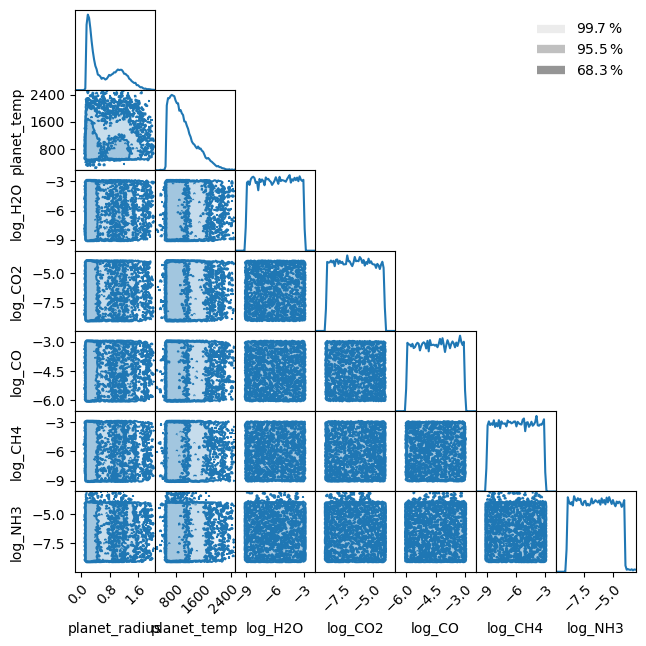

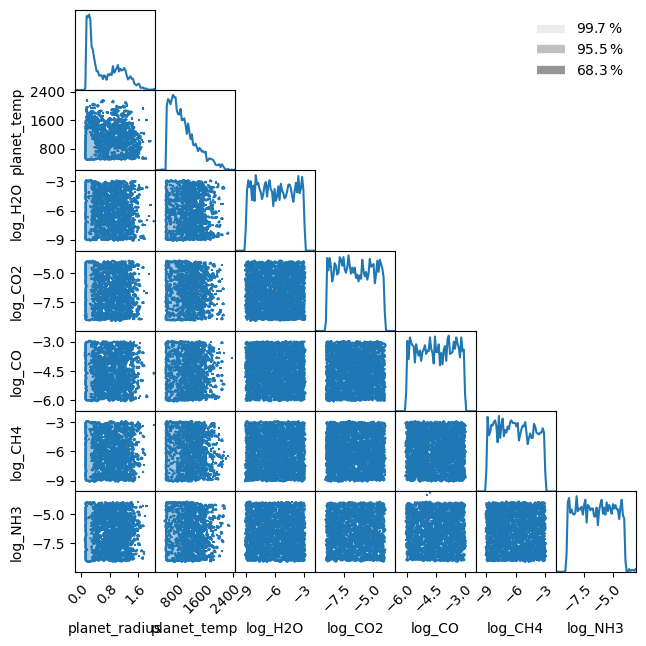

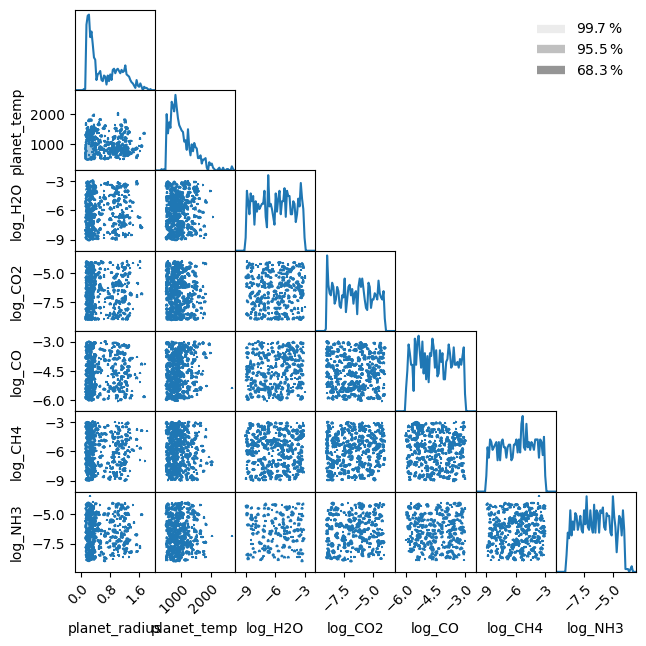

In [15]:
%matplotlib inline
trainset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/training_dataset.h5')
valset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/validation_dataset.h5')
testset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/testing_dataset.h5')

para_names = ['planet_radius', 'planet_temp', 'log_H2O', 'log_CO2', 'log_CO', 'log_CH4', 'log_NH3']

train_dist = np.array([theta.cpu().numpy() for theta, __ in trainset])
val_dist = np.array([theta.cpu().numpy() for theta, __ in valset])
test_dist = np.array([theta.cpu().numpy() for theta, __ in testset])

for dist, name in zip([train_dist, val_dist, test_dist],
                      ["train", "val", "test"]):
    fig = corner(
        rescale_output(torch.tensor(dist), forward=False).cpu(),
        labels=para_names
    )

    fig.savefig(f'/home/lwelzel/Documents/git/maldcope/data/TrainingData/{name}.png', dpi=300)
    plt.clf()



## Estimator

In [16]:
state = torch.load('/home/lwelzel/Documents/git/maldcope/runs/sbiear_experiment1/state.pth', map_location='cpu')

estimator = NPEWithEmbedding()
estimator.load_state_dict(state)
estimator.cuda()
estimator.eval()
estimator.embedding.eval()
# print(estimator.cuda().eval())

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(count_parameters(estimator))

1402944


In [25]:
x = torch.randn(52, device="cuda").reshape((1, 1, 52))
y = estimator.embedding(x)
y.cpu()

dot_graph = make_dot(y, params=dict(estimator.named_parameters()), show_attrs=True, show_saved=True)
__ = dot_graph.render("dot_model_graph", directory="/home/lwelzel/Documents/git/maldcope/", )

model_graph = draw_graph(estimator.embedding, input_size=(1, 1, 52), device='cuda')
fig = model_graph.visual_graph
__ = fig.render("graph_model_graph", directory="/home/lwelzel/Documents/git/maldcope/")


## Coverage

830


500pair [01:14,  6.72pair/s]


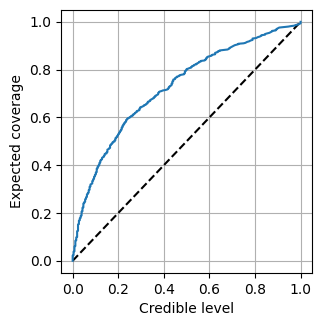

In [27]:
# TEST SET COVERAGE
testset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/testing_dataset.h5')
print(len(testset))
n_max = 500

train_iterator = ((theta.cuda(), x[0].cuda().reshape(-1, 1, 52)) for theta, x in islice(testset, n_max))

levels, coverages = expected_coverage_mc(estimator.flow,
                                         train_iterator,
                                         n=256)

plt.close("all")
fig = coverage_plot(levels, coverages)
fig.savefig("/home/lwelzel/Documents/git/maldcope/test_coverage.png", dpi=400)

37280


500pair [01:15,  6.64pair/s]


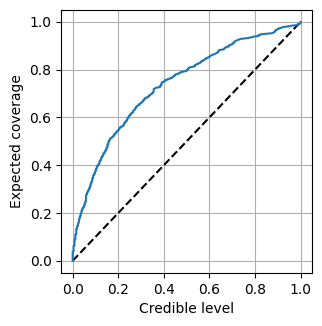

In [26]:
# TRAIN SET COVERAGE
trainset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/training_dataset.h5')
print(len(trainset))
n_max = 500

train_iterator = ((theta.cuda(), x[0].cuda().reshape(-1, 1, 52)) for theta, x in islice(trainset, n_max))

levels, coverages = expected_coverage_mc(estimator.flow,
                                         train_iterator,
                                         n=256)

plt.close("all")
fig = coverage_plot(levels, coverages)
fig.savefig("/home/lwelzel/Documents/git/maldcope/train_coverage.png", dpi=400)

## Corner

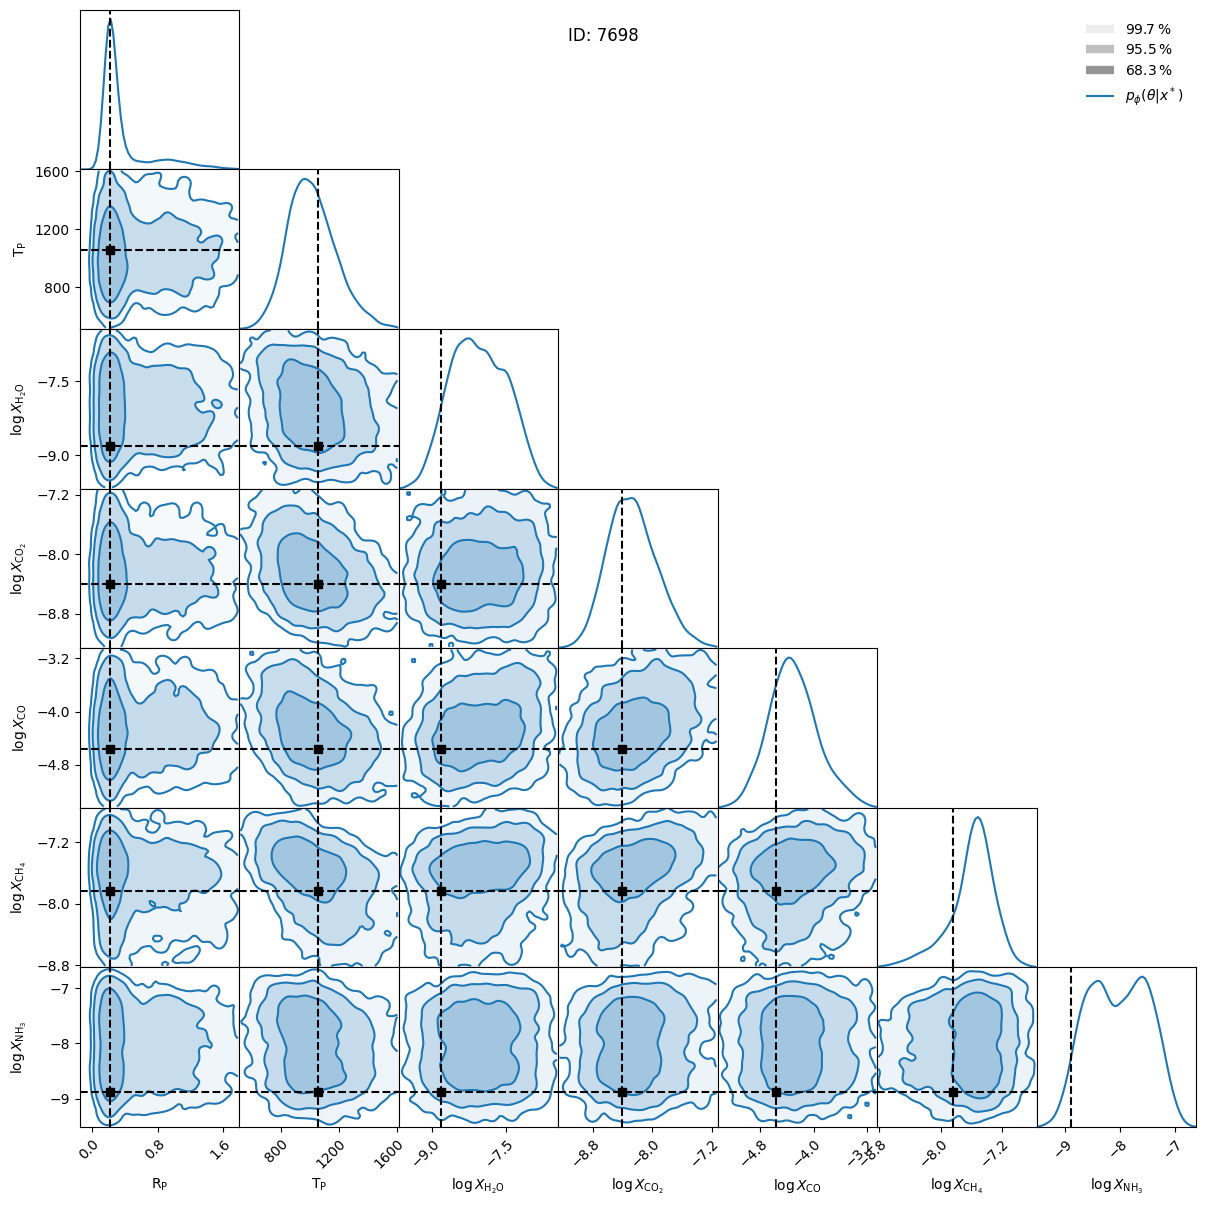

In [19]:
%matplotlib inline
trainset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/training_dataset.h5')
sample_id = np.random.randint(0, 30000)
theta_star, x_star = trainset[sample_id]
theta_star, x_star = theta_star.cuda(), x_star.cuda()
x_star = x_star[0].reshape((1, 1, -1))

with torch.no_grad():
    theta = estimator.flow(x_star.cuda()).sample((2**12,)).cpu()

theta = rescale_output(theta, forward=False).cpu()
theta_star = rescale_output(theta_star, forward=False).cpu()

LABELS, LOWER, UPPER = zip(*[
    [        r'${\rm R_{P}}$', -1e2,   1e2],  # planet_radius
    [        r'${\rm T_{P}}$', -1e2,   1e2],  # planet_temp
    [r'$\log X_{\rm H_{2}O}$', -1e2,   1e2],  # log_H2O
    [r'$\log X_{\rm CO_{2}}$', -1e2,   1e2],  # log_CO2
    [    r'$\log X_{\rm CO}$', -1e2,   1e2],  # log_CO
    [r'$\log X_{\rm CH_{4}}$', -1e2,   1e2],  # log_CH4
    [r'$\log X_{\rm NH_{3}}$', -1e2,   1e2],  # log_NH3
])

fig = corner(
    theta.reshape((-1, 7)),
    smooth=2,
    domain=None, # (LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_{\phi}(\theta | x^*)$',
    figsize=(12, 12),
)
fig.suptitle(f"ID: {sample_id}")
mark_point(fig, theta_star.cpu())
fig.savefig("/home/lwelzel/Documents/git/maldcope/random_corner.png", dpi=300)

In [43]:
plt.close("all")

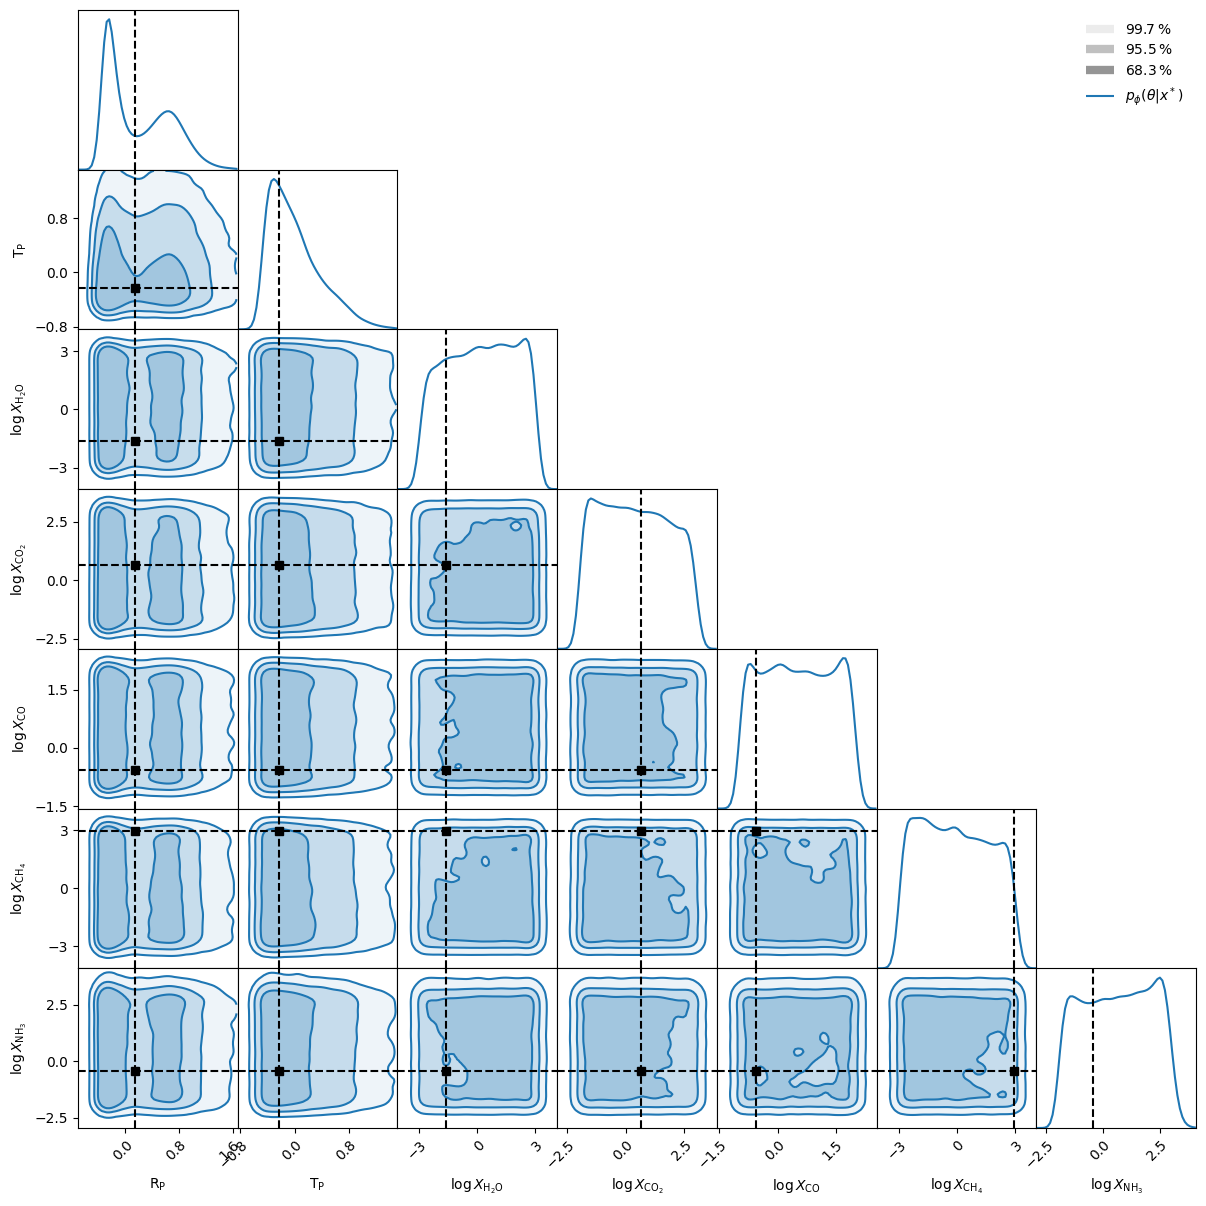

In [21]:
%matplotlib inline
testset = H5Dataset('/home/lwelzel/Documents/git/maldcope/data/TrainingData/testing_dataset.h5')
theta_star, x_star = testset[260]
theta_star, x_star = theta_star.cuda(), x_star.cuda()
x_star = x_star[0].reshape((1, -1))

with torch.no_grad():
    theta = estimator.flow(x_star.cuda()).sample((2**16,)).cpu()

LABELS, LOWER, UPPER = zip(*[
    [        r'${\rm R_{P}}$', -1e2,   1e2],  # planet_radius
    [        r'${\rm T_{P}}$', -1e2,   1e2],  # planet_temp
    [r'$\log X_{\rm H_{2}O}$', -1e2,   1e2],  # log_H2O
    [r'$\log X_{\rm CO_{2}}$', -1e2,   1e2],  # log_CO2
    [    r'$\log X_{\rm CO}$', -1e2,   1e2],  # log_CO
    [r'$\log X_{\rm CH_{4}}$', -1e2,   1e2],  # log_CH4
    [r'$\log X_{\rm NH_{3}}$', -1e2,   1e2],  # log_NH3
])

fig = corner(
    theta.reshape(-1, 7),
    smooth=2,
    domain=None, # (LOWER, UPPER),
    labels=LABELS,
    legend=r'$p_{\phi}(\theta | x^*)$',
    figsize=(12, 12),
)

mark_point(fig, theta_star.cpu())

## PT-profile

In [ ]:
theta_star, x_star = theta_star.double().numpy(), x_star.double().numpy()
theta = theta[:256].double().numpy()

pressure = simulator.atmosphere.press / 1e6
temperature = pt_profile(theta, pressure)
temperature_star = pt_profile(theta_star, pressure)

In [ ]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

for q in [0.997, 0.95, 0.68]:
    left, right = np.quantile(temperature, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax.fill_betweenx(pressure, left, right, color='C0', alpha=0.25, linewidth=0)

ax.plot(temperature_star, pressure, color='k', linestyle='--')

ax.set_xlabel(r'Temperature $(\mathrm{K})$')
ax.set_xlim(0, 4000)
ax.set_ylabel(r'Pressure $(\mathrm{bar})$')
ax.set_ylim(1e-2, 1e1)
ax.set_yscale('log')
ax.invert_yaxis()
ax.grid()

## Consistency

In [ ]:
x = np.stack([simulator(t) for t in tqdm(theta)])

mask = ~np.isnan(x).any(axis=-1)
theta, x = theta[mask], x[mask]

wlength = np.linspace(0.95, 2.45, x.shape[-1])

In [ ]:
fig, ax = plt.subplots(figsize=(4.8, 4.8))

for q in [0.997, 0.95, 0.68]:
    lower, upper = np.quantile(x, [0.5 - q / 2, 0.5 + q / 2], axis=0)
    ax.fill_between(wlength, lower, upper, color='C0', alpha=0.25, linewidth=0)

ax.plot(wlength, x_star, color='k', linestyle=':')

ax.set_xlabel(r'Wavelength $(\mu\mathrm{m})$')
ax.set_ylabel(r'Flux $(\mathrm{W} \, \mathrm{m}^{-2} \, \mu\mathrm{m}^{-1})$')
ax.grid()